Lab Distribution：
target
0.0    464748
1.0     15450
Name: count, dtype: int64
Epoch 1/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - auc: 0.5281 - f1_score: 0.5516 - loss: 0.1685 - val_auc: 0.6759 - val_f1_score: 0.1342 - val_loss: 0.0754 - learning_rate: 1.0000e-04
Epoch 2/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - auc: 0.5712 - f1_score: 0.5356 - loss: 0.1167 - val_auc: 0.7281 - val_f1_score: 0.1546 - val_loss: 0.0734 - learning_rate: 1.0000e-04
Epoch 3/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - auc: 0.6135 - f1_score: 0.5356 - loss: 0.1094 - val_auc: 0.7567 - val_f1_score: 0.1657 - val_loss: 0.0707 - learning_rate: 1.0000e-04
Epoch 4/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - auc: 0.6616 - f1_score: 0.5756 - loss: 0.1058 - val_auc: 0.7708 - val_f1_score: 0.1653 - val_loss: 0.0679 - learning_rate: 1.0000e-04
Epoch 5/100
945/945 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - auc: 0.7029 - f1_score: 0.6167 - loss: 0.1023 - val_auc: 0.7777 - val_f1_score: 0.1525 - val_loss: 0

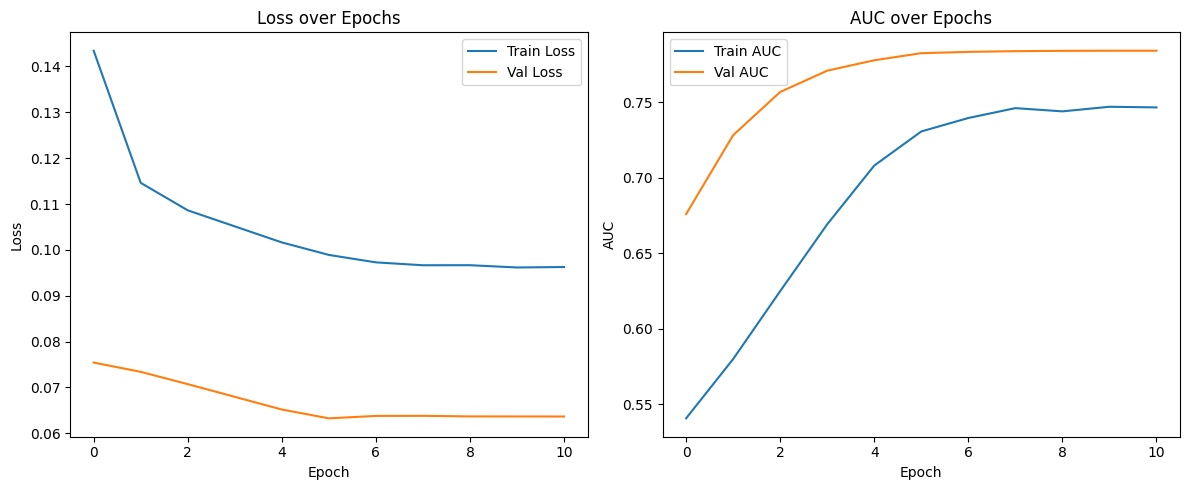

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import ADASYN


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, PReLU
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.losses import Loss
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline 


@register_keras_serializable()
class BinaryFocalLoss(Loss):
    def __init__(self, gamma=2.0, alpha=0.7, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(self.alpha * K.pow(1. - pt_1, self.gamma) * K.log(pt_1)) \
               -K.mean((1 - self.alpha) * K.pow(pt_0, self.gamma) * K.log(1. - pt_0))

    def get_config(self):
        return {"gamma": self.gamma, "alpha": self.alpha}
    
@register_keras_serializable()
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_bin = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        self.tp.assign_add(tf.reduce_sum(y_true * y_pred_bin))
        self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred_bin))
        self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred_bin)))

    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-8)
        recall = self.tp / (self.tp + self.fn + 1e-8)
        return 2 * precision * recall / (precision + recall + 1e-8)

    def reset_states(self):
        self.tp.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)

    def get_config(self):
        return {'threshold': self.threshold}


df = pd.read_parquet("../data/train_data.parquet")


categorical_cols = df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))


drop_cols = ["case_id", "date_decision", "target"]
X = df.drop(columns=drop_cols)
y = df["target"]


print("Lab Distribution:")
print(y.value_counts())


X_train_raw, X_test_raw, y_train_raw, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


pipeline = Pipeline([
    ('undersample', RandomUnderSampler(sampling_strategy=0.4, random_state=42)),  
    ('oversample', ADASYN(sampling_strategy=0.9, random_state=42))                
])
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train_raw, y_train_raw)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled).astype(np.float32)
X_test_scaled = scaler.transform(X_test_raw).astype(np.float32)

joblib.dump(scaler, "../output/model/scaler.pkl")


y_train = y_train_resampled.astype(np.float32)
y_test = y_test.astype(np.float32)


model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=BinaryFocalLoss(gamma=2.5, alpha=0.5),
    metrics=[F1Score(name='f1_score'), AUC(name="auc")]
)


rlr = ReduceLROnPlateau(monitor='val_f1_score', factor=0.1, patience=3,
                        verbose=1, min_delta=1e-4, mode='max')

early_stop = EarlyStopping(monitor='val_f1_score', mode='max', patience=8, restore_best_weights=True)

checkpoint = ModelCheckpoint("../output/model/nn_best_model.keras",
                             monitor='val_f1_score', mode='max', save_best_only=True)

class_weight = {0: 1.0, 1: 2.0} 


history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=64,
    class_weight=class_weight,
    callbacks=[rlr, early_stop, checkpoint],
    verbose=1
)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


1889/1889 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


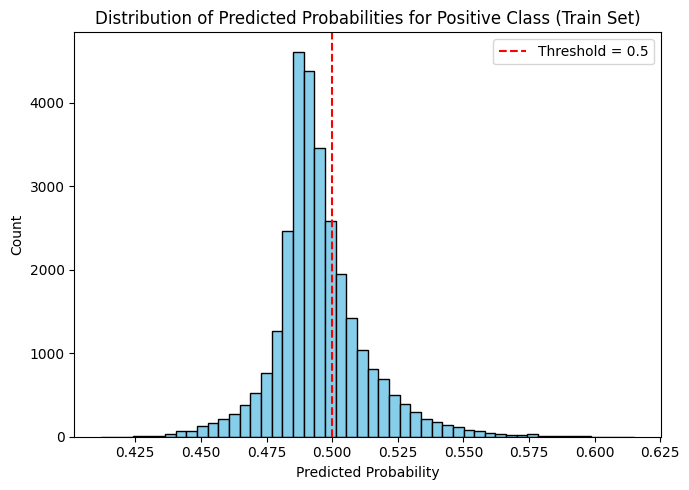

In [30]:
y_train_true = y_train_resampled
X_train_input = X_train_scaled  


y_train_pred_prob = model.predict(X_train_input).flatten()


pos_probs = y_train_pred_prob[y_train_true == 1]


import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.hist(pos_probs, bins=50, color='skyblue', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.title("Distribution of Predicted Probabilities for Positive Class (Train Set)")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()